In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from datetime import datetime, timedelta
import os

<h3>Read in the data</h3>

In [3]:
def read_netCDF4_data(filename):
    with Dataset(filename) as rootgrp:
        longitude = rootgrp['longitude'][:]
        latitude = rootgrp['latitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        temperature = rootgrp['t'][:, :, :, :]
        print(rootgrp['time'])
    return longitude, latitude, level, time, temperature

In [5]:
longitude, latitude, level, time, temperature = read_netCDF4_data('/fmi/projappl/project_2001985/jamin/data/T_profile_2010_2020.nc')

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (132,)
filling on, default _FillValue of -2147483647 used


In [4]:
T_profiles = np.load('temperature_profiles.npy')

In [5]:
T_profiles.shape

(137047680, 19)

Note that the temperature profiles (*temperature_profiles.npy*) have been created in the following way:

``` python
def read_netCDF4_data(filename):
    """
    Read in the temperature data.
    """
    with Dataset(filename) as rootgrp:
        print(rootgrp)
        longitude = rootgrp['longitude'][:]
        latitude = rootgrp['latitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        temperature = rootgrp['t'][:][:][:][:]
    return longitude, latitude, level, time, temperature

path = "/fmi/projappl/project_2001985/jamin/data/T_profile_2010_2020.nc"
longitude, latitude, level, time, temperature = read_netCDF4_data(path)
temperature.shape
>>> (132, 19, 721, 1440)

def create_temperature_profiles(t):
    """
    This function creates temperature profiles such that
    each column represent one pressure level.
    For example, the first column has the temperatures associated
    with pressure level 1.
    
    parameters:
        t: a 4D tensor containing time, pressure level, latitude, longitude.
        
    returns:
        2D matrix where each column represents one pressure level.
    """
    i = 0
    T_profiles = np.zeros((t[:, 0, :, :].size, t[0, :, 0, 0].size), float)
    for day in range(0, len(time)):
        #print(day)
        for lat in range(0, len(latitude)):
            for lon in range(0, len(longitude)):
                T_profiles[i, :] = t[day, :, lat, lon][None, :]
                i += 1
    return T_profiles

temperature_profiles = create_temperature_profiles(temperature)
temperature_profiles.shape
>>> (137047680, 19)
# Save the temperature profiles (it takes very long time to produce them)
np.save("temperature_profiles.npy", temperature_profiles)
```

<h3>Boxplots on the complete temperature profiles (all data)</h3>

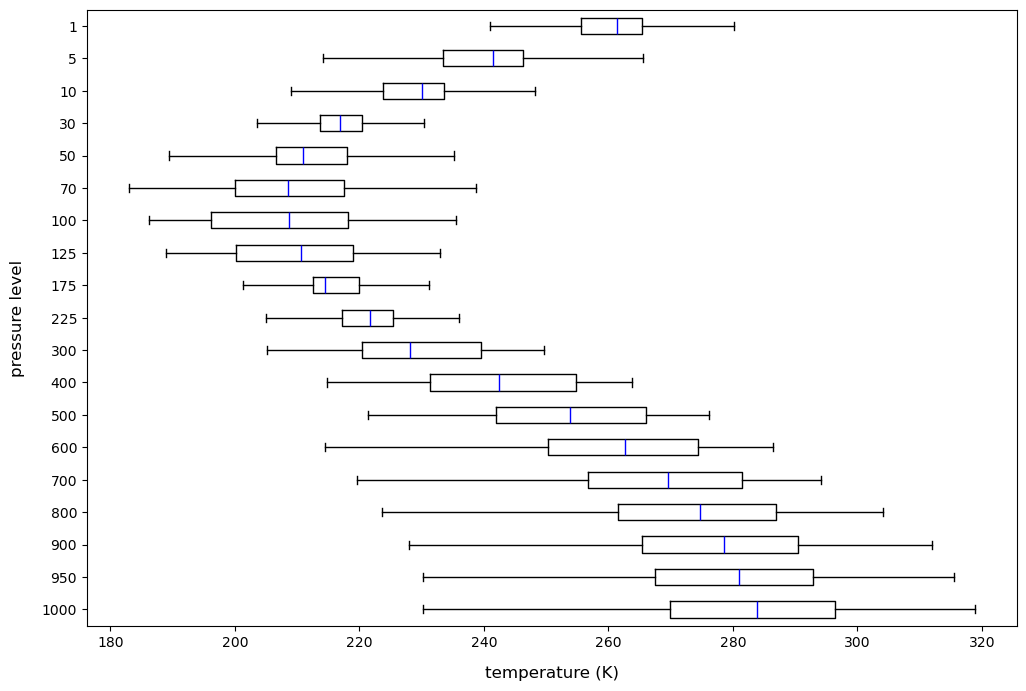

In [71]:
plt.figure(figsize=(12,8), dpi=100)
plt.boxplot(T_profiles, 
            vert=False, 
            showfliers=False, 
            medianprops=dict(color="blue"))
plt.xlabel('temperature (K)', size=12, labelpad=12)
plt.ylabel('pressure level', size=12, labelpad=12)
plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
plt.gca().invert_yaxis();

<h3>Grouping the data by season</h3>

In [6]:
def group_data_by_season(time_data, temperature_data):
    """
    Function info here.
    
    Parameters:
        time_data: data containing the days (as hours) of the measurements.
        temperature_data: data containing the temperature measurements.
        
    Returns:
        Grouped temperature data by season.
        (Q1: Dec, Jan, Feb
         Q2: Mar, April, May
         Q3: Jun, Jul, Aug
         Q4: Sep, Oct, Nov)
    """
    # Convert time to dates. 
    # Note that the elements in the time variable are in hours,
    # So we are converting from hours to dates (YY-MM-DD)
    def hours_to_dates(t):
        dates = []
        for h in t:
            base_date = datetime(1900, 1, 1, 0, 0, 0)
            time_delta = timedelta(hours=int(h))
            resulting_date = base_date + time_delta
            dates.append(resulting_date.date())
        return dates
    
    dates = hours_to_dates(time_data)    
    
    # Extract the months from the datetime.date objects
    months = np.array([d.month for d in dates])

    # Create masks for Q1, Q2, Q3, Q4
    mask_Q1 = months[np.isin(months, [12, 1, 2])]
    mask_Q2 = months[np.isin(months, [3, 4, 5])]
    mask_Q3 = months[np.isin(months, [6, 7, 8])]
    mask_Q4 = months[np.isin(months, [9, 10, 11])]
    
    # Group the data
    Q1 = temperature[mask_Q1, :, :, :]
    Q2 = temperature[mask_Q2, :, :, :]
    Q3 = temperature[mask_Q3, :, :, :]
    Q4 = temperature[mask_Q4, :, :, :]
    
    return Q1, Q2, Q3, Q4

In [7]:
Q1, Q2, Q3, Q4 = group_data_by_season(time, temperature)

In [8]:
for q in [Q1, Q2, Q3, Q4]:
    print(q.shape)

(33, 19, 721, 1440)
(33, 19, 721, 1440)
(33, 19, 721, 1440)
(33, 19, 721, 1440)


- 33 months in every quartal, which makes sense, since there is 11 years of data $\, (11 * 12 = 132, \,$ and $\, \frac{132}{4} = 33)$.

In [9]:
np.mean(np.mean(Q1, axis=0), axis=2).shape

(19, 721)

<h3>Remaking the temperature profiles</h3>

In [1]:
def create_temperature_profiles(t):
    # Copy of the original data
    t_copy = np.array(t.copy())
    # Average along the time dimensions (quartal)
    t_copy = np.mean(t_copy, axis=0)
    # Average along the longitude dimension
    t_copy = np.mean(t_copy, axis=2)
    
    # Define the bin size
    bin_size = 40
    last_bin_size = 41
    
    n_lat = t_copy.shape[1]
    n_levels = t_copy.shape[0]

    # Calculate the index where the last bin should start
    last_bin_start = n_lat - last_bin_size
    
    arr = np.zeros(shape=(18, 19), dtype=float)
    for level in range(n_levels):
        b = []
        for i in range(0, n_lat - last_bin_size - 1, bin_size):
            vals = t_copy[level, :][i:(i+bin_size)]
            b.append(vals)
        b.append(t_copy[level, :][last_bin_start:])
        arr[:, level] = np.array([np.mean(i) for i in b])
    return arr

In [11]:
Q1_profiles = create_temperature_profiles(Q1)
Q2_profiles = create_temperature_profiles(Q2)
Q3_profiles = create_temperature_profiles(Q3)
Q4_profiles = create_temperature_profiles(Q4)

In [12]:
Q1_profiles.shape

(18, 19)

In [13]:
Q1_profiles[0, :].size

19

In [16]:
type(Q1_profiles)

numpy.ndarray

<br>

<h3>Saving the profiles</h3>

In [17]:
def save_data(data, filename):
    with Dataset(f"{filename}.nc", "w", format="NETCDF4") as nc:
        # Description
        nc.description = '123'
        # Dimensions
        nc.createDimension("rows", None)
        nc.createDimension("columns", None)
        # Variables
        nc = nc.createVariable("data", "f8", ("rows", "columns"))
        # Attributes
        nc.longname = "Seasonal temperature profile"
        # Assigning values
        nc[:, :] = data

In [19]:
save_data(Q1_profiles, 'Q1_profiles')
save_data(Q2_profiles, 'Q2_profiles')
save_data(Q3_profiles, 'Q3_profiles')
save_data(Q4_profiles, 'Q4_profiles')

<br>

In [80]:
def plot_box_profile(ax, data, title):
    ax.boxplot(data,
               vert=False,
               showfliers=False,
               medianprops=dict(color='blue'))
    ax.set_xlabel('temperature (K)', size=12, labelpad=12)
    ax.set_ylabel('pressure level', size=12, labelpad=12)
    ax.set_yticks(ticks=np.arange(1, len(level) + 1))
    ax.set_yticklabels(level)
    ax.set_title(title)
    ax.invert_yaxis();

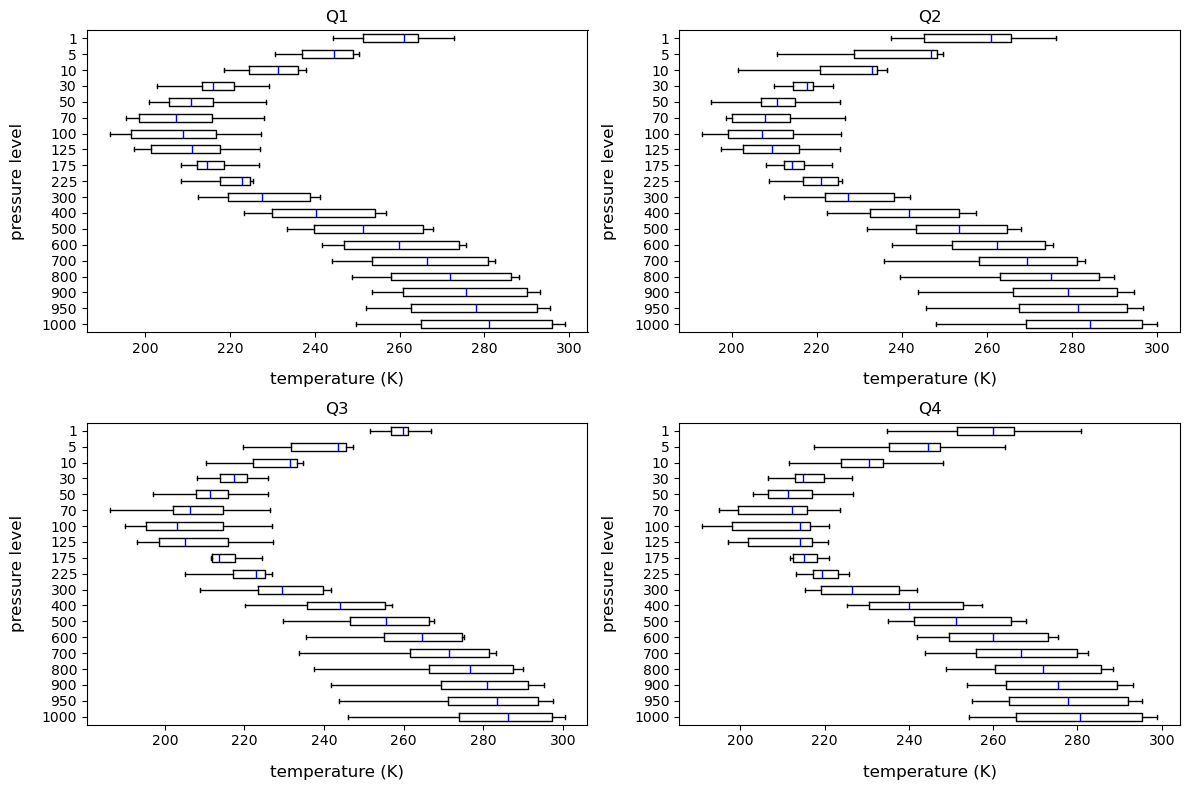

In [81]:
fig, ax = plt.subplots(figsize=(12,8), nrows=2, ncols=2, dpi=100)
plot_box_profile(ax[0, 0], Q1_profiles, 'Q1')
plot_box_profile(ax[0, 1], Q2_profiles, 'Q2')
plot_box_profile(ax[1, 0], Q3_profiles, 'Q3')
plot_box_profile(ax[1, 1], Q4_profiles, 'Q4')
plt.tight_layout();

<br>

In [82]:
def plot_x(data, title):
    
    # Latitude upper and lower boundary for the legends
    lat_deg_upper = 80
    lat_deg_lower = 70
    label=''
    
    # Plot each temperature profile
    for p in range(data.shape[0]):
        
        # For the legend display
        if p == 0:
            label=f'x > {lat_deg_upper}'
        elif p == 17:
            label=f'x < {lat_deg_upper}'
        else:
            label=f'{lat_deg_upper} > x >= {lat_deg_lower}'
        
        # Plot the temperature profile
        plt.plot(data[p, :], 
                 np.arange(1, len(level) + 1), 
                 linestyle='-', 
                 linewidth=2,
                 label=label)
        
        # Decrease both upper and lower boundaries of the lat degree
        if p != 0:
            lat_deg_upper -= 10
            lat_deg_lower -= 10
        
        # Set labels, make legend visible and invert the y-axis
        plt.xlabel('temperature (K)', size=12, labelpad=12)
        plt.ylabel('pressure level', size=12, labelpad=12)
        plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.legend(bbox_to_anchor=(1, 1));

<br>

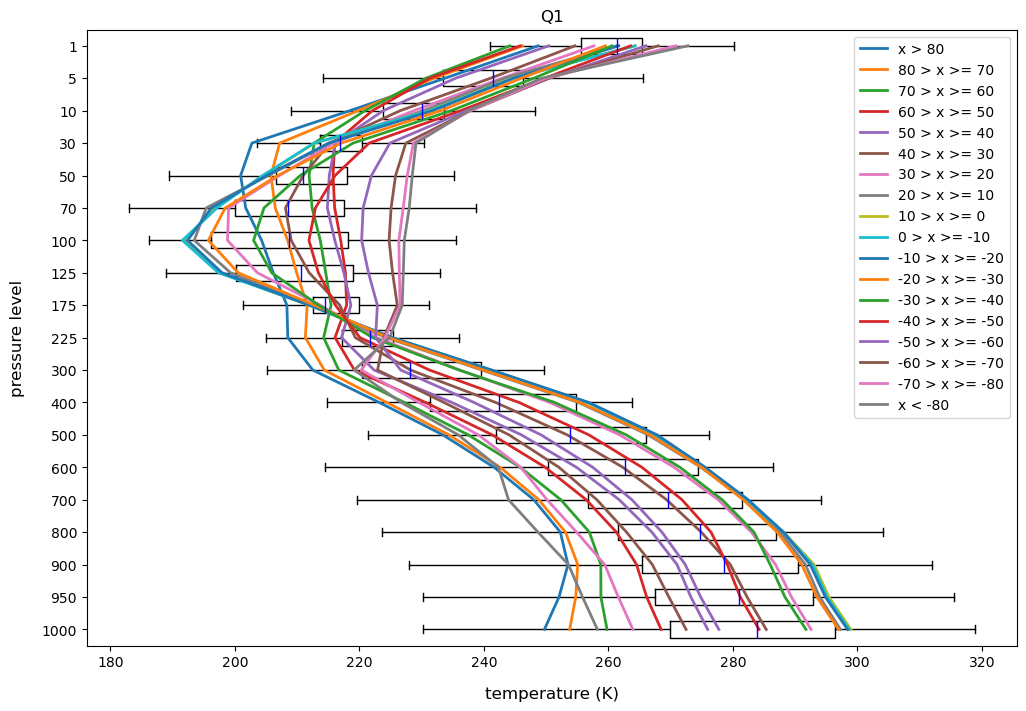

In [83]:
plt.figure(figsize=(12,8), dpi=100)
plt.boxplot(T_profiles, 
            vert=False, 
            showfliers=False, 
            medianprops=dict(color="blue"))
plt.xlabel('temperature (K)', size=12, labelpad=12)
plt.ylabel('pressure level', size=12, labelpad=12)
plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
plt.gca().invert_yaxis()

plot_x(Q1_profiles, 'Q1')

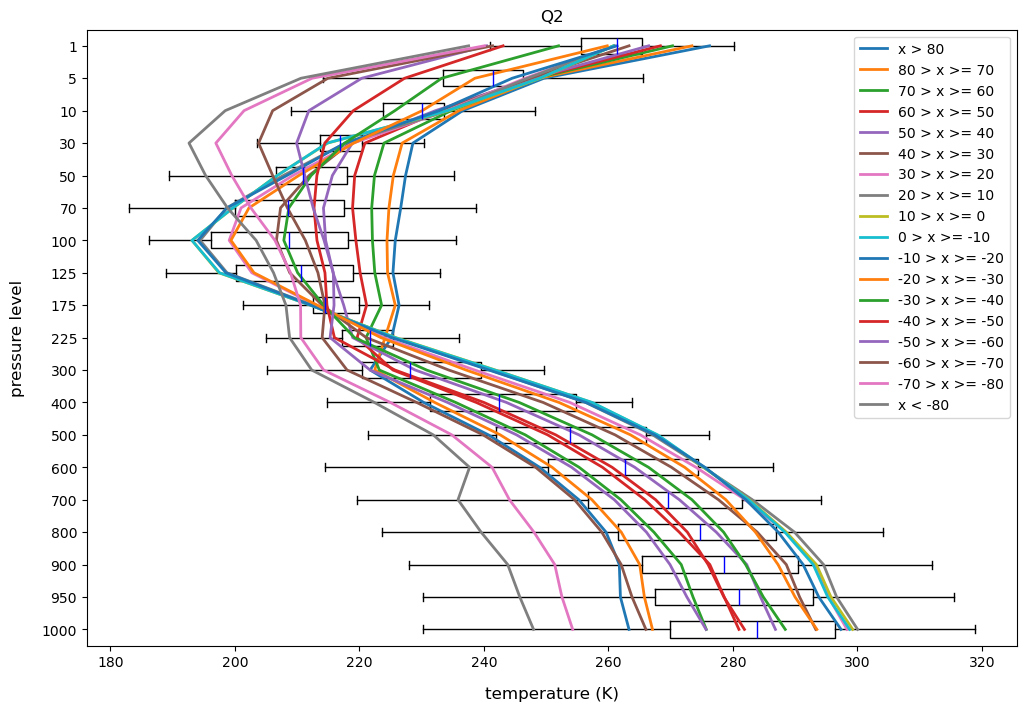

In [84]:
plt.figure(figsize=(12,8), dpi=100)
plt.boxplot(T_profiles, 
            vert=False, 
            showfliers=False, 
            medianprops=dict(color="blue"))
plt.xlabel('temperature (K)', size=12, labelpad=12)
plt.ylabel('pressure level', size=12, labelpad=12)
plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
plt.gca().invert_yaxis()

plot_x(Q2_profiles, 'Q2')

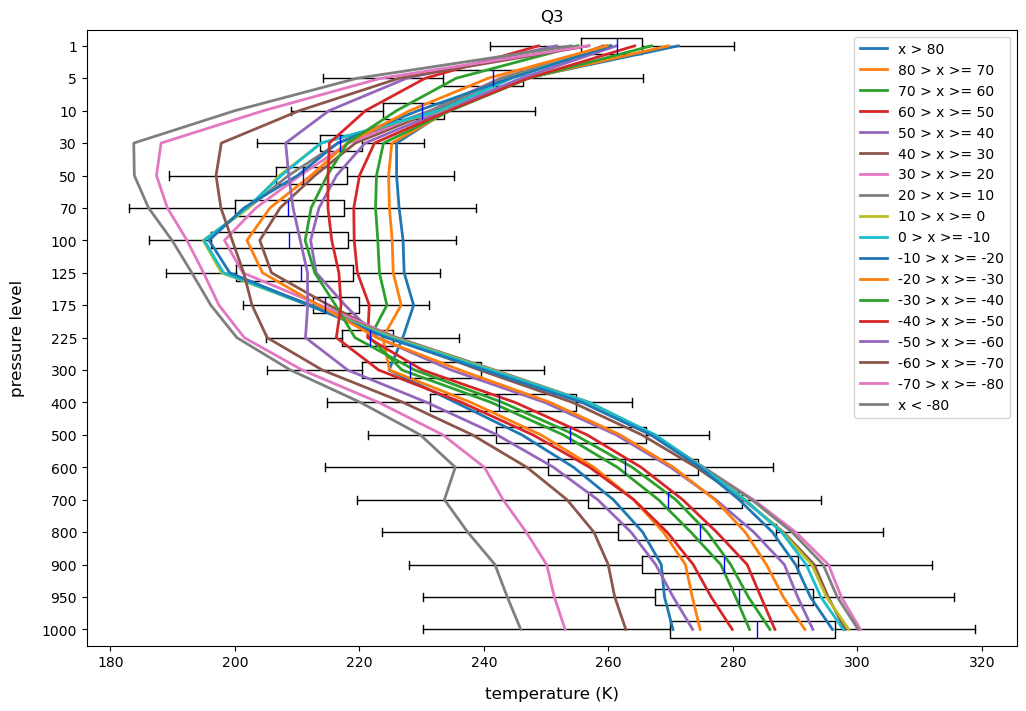

In [85]:
plt.figure(figsize=(12,8), dpi=100)
plt.boxplot(T_profiles, 
            vert=False, 
            showfliers=False, 
            medianprops=dict(color="blue"))
plt.xlabel('temperature (K)', size=12, labelpad=12)
plt.ylabel('pressure level', size=12, labelpad=12)
plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
plt.gca().invert_yaxis()

plot_x(Q3_profiles, 'Q3')

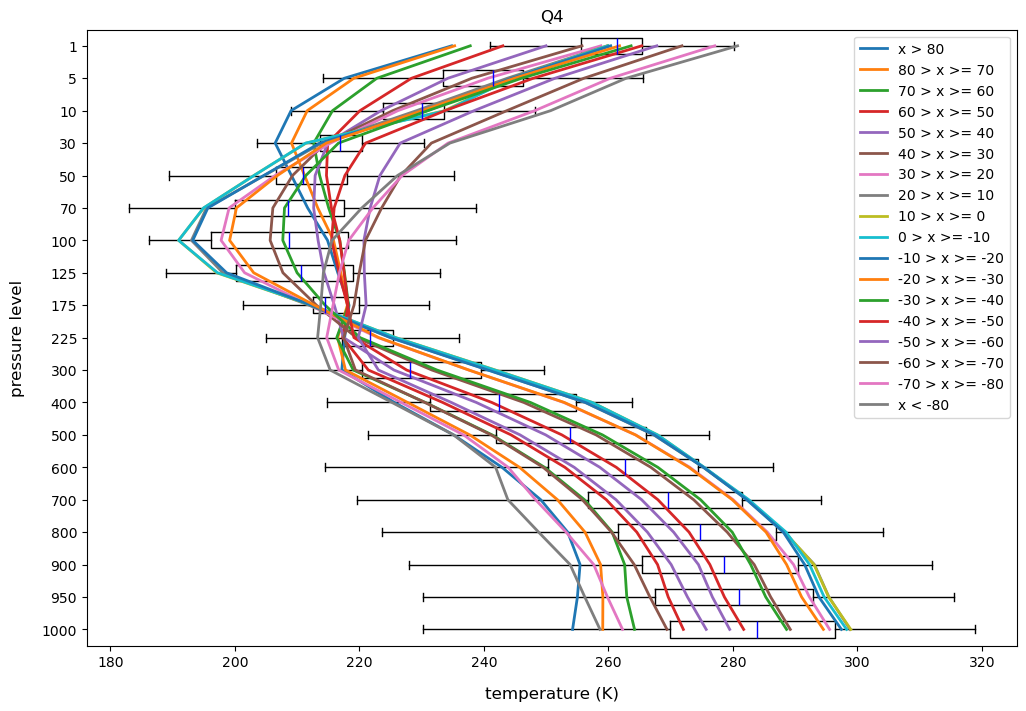

In [86]:
plt.figure(figsize=(12,8), dpi=100)
plt.boxplot(T_profiles, 
            vert=False, 
            showfliers=False, 
            medianprops=dict(color="blue"))
plt.xlabel('temperature (K)', size=12, labelpad=12)
plt.ylabel('pressure level', size=12, labelpad=12)
plt.yticks(ticks=np.arange(1, len(level) + 1), labels=level)
plt.gca().invert_yaxis()

plot_x(Q4_profiles, 'Q4')